<h1><center>Primal Dual Hybrid Gradient Algorithm: Part II (Tomography) </center></h1>

In this part, we focus on Tomography reconstruction using PDHG algorithm. We will use a __Total variation regularisation__ and compared our TV reconstruction with 

- __Filtered BackProjection (FBP)__, 
- __Conjugate Gradient Least Squares (CGLS)__ and 
- __Simultaneous Iterative Reconstruction Technique (SIRT)__.

The minimisation problem is described below:

<a id='TomoProblem'></a>
$$ \underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} + \alpha\,\mathrm{TV}(u) +  \mathbb{I}_{\{u>0\}}(u) $$

where,

1. g is the Acqusisition data obtained from the detector.
1. $\mathcal{A}$ is the projection operator ( _Radon transform_ ) that maps from an image-space to an acquisition space, i.e., $$\mathcal{A} : X \rightarrow Y, $$ where X is an __ImageGeometry__ and Y is an __AcquisitionGeometry__.
1. $\mathbb{I}_{\{u>0\}}$ a positivity constraint.


## Learning objectives

1. Define AcquisitionGeometry, ImageGeometry and Projection operator for our tomography problem.
1. Run standard iterative reconstruction techniques such as FBP, SIRT and CGLS.
1. Setup PDHG for Tomography reconstuction using a Total Variation regulariser.
1. Use PDHG with the __BlockFramework__ and with the __CCPi-Regularisation Toolkit__.

## Prerequisites

- AcquisitionData, AcquisitionGeometry.
- AstraProjectorSimple, AstraProjectorSimple3.
- FBP, SIRT, CGLS.
- BlockOperator, BlockFunction.

<h1><center> Example: Tomography Reconstuction</center></h1>   
<img src="images/tomo_all.jpeg"  width="800"/>

The setup of PDHG algorithm for tomography application is very similar to the denoising case. Before, we had a BlockOperator which contained a Gradient and an Identity operator,

$$ K =  \begin{bmatrix}
\nabla \\
\mathbb{I}
\end{bmatrix}.$$

Now, we replace the identity operator with the projection operator $\mathcal{A}$ and the BlockOperator is 

$$ K =  \begin{bmatrix}
\nabla \\
\mathcal{A}
\end{bmatrix}.$$

In [1]:
# Imports
from ccpi.framework import ImageData, ImageGeometry, AcquisitionGeometry, AcquisitionData

from ccpi.optimisation.functions import L2NormSquared, ZeroFunction, BlockFunction, MixedL21Norm, IndicatorBox, FunctionOperatorComposition
from ccpi.optimisation.operators import Gradient, BlockOperator
from ccpi.optimisation.algorithms import PDHG, SIRT, CGLS

from ccpi.astra.operators import AstraProjectorSimple, AstraProjector3DSimple
from ccpi.astra.processors import FBP

from ccpi.plugins.regularisers import FGP_TV

import tomophantom
from tomophantom import TomoP2D, TomoP3D
import os

import matplotlib.pyplot as plt

import numpy as np

from utilities import islicer
from utilities.show_utilities import show

First, we load a phantom, from the [tomophantom](https://github.com/dkazanc/TomoPhantom) package. We can
choose different 2D,3D & 4D phantoms from this [library](https://github.com/dkazanc/TomoPhantom/tree/master/PhantomLibrary/models). For the well-known Shepp-Logan phantom, use _model = 1_ in the code below.

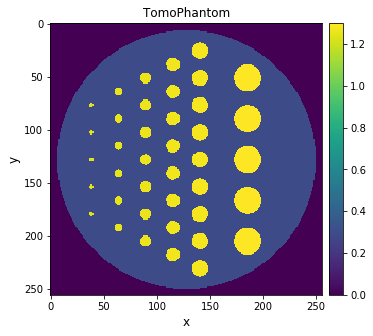

In [2]:
model = 4 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom = TomoP2D.Model(model, N, path_library2D) 

# Define image geometry.
ig = ImageGeometry(voxel_num_x = N, voxel_num_y = N)
im_data = ig.allocate()
im_data.fill(phantom)

show(im_data, title = 'TomoPhantom')

Next step is to create an acquisition data, using the tomophantom. We need to define an acquisition space, where this data belongs to. This acquisition space, will help us to define our (linear) operator A as 

$$\mathcal{A}: \mathrm{ImageGeometry} \rightarrow \mathrm{AcquisitionGeometry}$$

For this task, we use a detector with _ 2D parallel geometry_, described in the figures below. 
- ImageData is the tomophantom of size (N,N) that is an element of ImageGeometry. 
- For the acquisition geometry, we need to specify
    1. The type of geometry
    1. The number of detectors
    1. The number of angles. Note we need them in radians.

<img src="images/parallel_data.png" width="350" align="left" style="margin-right: 75px"/>
<img src="images/parallel_geometry.png" width="470"  align="left"/>   

The projection operator $\mathcal{A}$ has two methods __direct__ and __adjoint__ that compute the __forward__ and __backward__ projection. Therfore, if we want to project and obtain an AcquisitionData we write

- _sino = A.direct(tomophantom)_ 

and to backproject 

- _recon = A.adjoint(sino)_.

Below, we define our AcquisitionGeometry and AcquisitionData. 

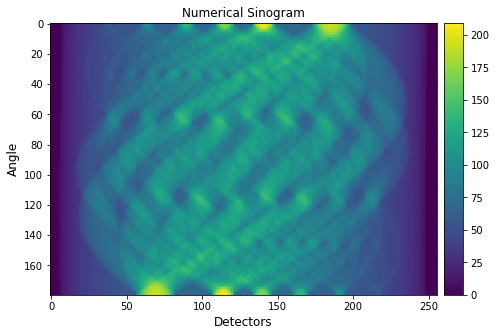

In [3]:
# Create AcquisitionGeometry and AcquisitionData 
detectors = N
angles = np.linspace(0, np.pi, 180, dtype='float32')
ag = AcquisitionGeometry('parallel','2D', angles, detectors)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = AstraProjectorSimple(ig, ag, device='gpu')

# Create an acqusition data (numerically)
sino_num = A.direct(im_data)

# Show numerical sinogram
show(sino_num, title = 'Numerical Sinogram', labels = ['Detectors','Angle'])

### FBP, SIRT and CGLS reconstructions

Let's now try: 

1. A filtered back projection reconstruction, using a _Ram-Lak_ filter.
1. A Simultaneous Iterative Reconstruction Technique (SIRT):
    
    __(Reminder)__ : If A u = g, then SIRT algorithm:  $$u^{k+1} = \mathcal{P}_{C}(u^{k} + D A^{T} M ( g - A u^{k}))$$ where,
    
    $$
    \begin{cases}
    M = \frac{\mathbb{1}}{A\mathbb{1}}, \quad m_{ii} = \frac{1}{\sum_{j} a_{ij}}, \quad\mbox{ sum over columns }\\
    D = \frac{\mathbb{1}}{A^{T}\mathbb{1}}, \quad d_{jj} = \frac{1}{\sum_{i} a_{ij}}\quad\mbox{ sum over rows }\\
    \end{cases}
    $$
1. CGLS reconstruction.

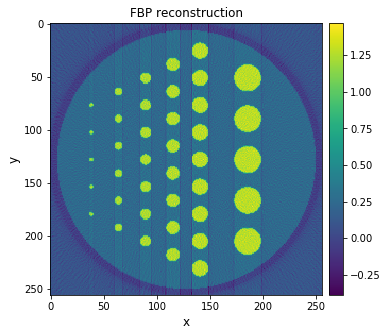

In [4]:
# FBP reconstruction
fbp = FBP(ig, ag, filter_type = 'ram-lak')
fbp.set_input(sino_num)
fbp_recon = fbp.get_output()
show(fbp_recon, title = 'FBP reconstruction')

SIRT setting up
SIRT configured


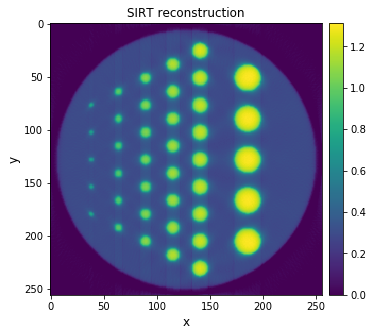

In [5]:
# Run SIRT algoritm, with positivity constraint

# Setup and run the SIRT algorithm  
x_init = ig.allocate()  

sirt = SIRT(x_init = x_init, operator = A, data=sino_num, constraint = IndicatorBox(lower=0),
           max_iteration = 50)
sirt.run(verbose=False)

sirt_recon = sirt.get_output()
show(sirt_recon, title = 'SIRT reconstruction')

CGLS setting up
CGLS configured


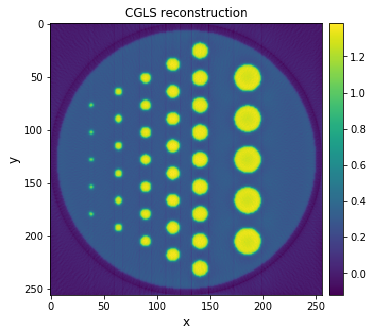

In [6]:
from ccpi.optimisation.algorithms import CGLS

cgls = CGLS(x_init = x_init, operator = A, data = sino_num, max_iteration = 10)
cgls.run(verbose=False)

cgls_recon = cgls.get_output()
show(cgls_recon, title = 'CGLS reconstruction')

## Total variation Tomography reconstuction

Now, we focus on TV reconstruction using the PDHG algorithm. We would like to write our [problem](#TomoProblem) in form below 

<a id='PDHG'></a>
$$ \underset{x\in X}{\operatorname{argmin}} F ( K x ) + G (x)$$

As we mention in the introduction, for a tomography reconstruction task, we have a BlockOperator K, with the Gradient and Projection operator.

$$ K = 
\begin{bmatrix}
\nabla\\
A
\end{bmatrix}
$$

Similar to TV denoising, the convex function F, is again a BlockFunction with a __MixedL21Norm()__ that represents the Total variation term and a __L2NormSquared(noisy_data)__ term that represents the data fitting term. Finally, for the convex function G, we let __G = IndicatorBox(lower=0)__ to enforce our positivity constraint for [problem](#TomoProblem).

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    3.44742e+08  -0.00000e+00    3.44742e+08
      100        200         0.008    5.22839e+07  -4.34761e+08    4.87045e+08
      200        200         0.007    2.26134e+04  -1.10787e+05    1.33401e+05


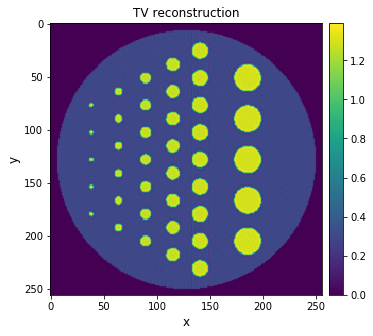

In [7]:
# Define Gradient Operator and BlockOperator 
Grad = Gradient(ig)
K = BlockOperator(Grad, A)

# Define BlockFunction F using the MixedL21Norm() and the L2NormSquared()
alpha = 2
f1 = alpha * MixedL21Norm()
f2 = L2NormSquared(sino_num)
F = BlockFunction(f1, f2)

# Define BlockFunction G, as a positivity constraint
G = IndicatorBox(lower=0)

# Compute operator norm and choose step-size sigma and tau such that sigma*tau||K||^{2}<1
normK = K.norm()
sigma = 1
tau = 1/(sigma * normK**2)

pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, 
            max_iteration = 200, update_objective_interval = 100)
pdhg.run(verbose = True)

pdhg_recon = pdhg.get_output()
show(pdhg_recon, title = 'TV reconstruction')

## PDHG without BlockFramework

In the above PDHG formulation, both of the primal/dual problems have a closed form solution. However, we can provide another formulation where the problem associated with the Total variation regulariser is computed iteratively. For more information, see page 60, [An introduction to continuous optimization for imaging, Champolle-Pock](https://hal.archives-ouvertes.fr/hal-01346507/document).

Recall, that we described the same methods in the previous demo for the denoising task, where we used an Identity operator.

Therefore, we would like to express [problem](#TomoProblem#) in this [form](#PDHG#)  __without__ using the __BlockFramework__. 

- Let $ K = \mathcal{A} $, i.e., the projection operator $\mathcal{A}: X \rightarrow Y$, where $X$ is the ImageGeometry and $Y$ the AcquisitionGeometry.
- Let $ F : Y \rightarrow \mathbb{R} $, with $$F(z) := \frac{1}{2}\| z - g \|^{2}, \quad \mbox{ for } z\in Y.$$
- Let $ G : X \rightarrow \mathbb{R} $, with $$G(z) := \alpha\|\nabla z\|_{2,1} = \alpha\,\mathrm{TV}(z)\quad\mbox{ for } z\in X.$$

Then, if $x = u\in X $, $$\underset{x}{\operatorname{argmin}} \mathcal{F}(Kx) + \mathcal{G}(x) = \underset{u}{\operatorname{argmin}} \mathcal{F}(\mathcal{A} u) + \mathcal{G}(u) = \underset{u}{\operatorname{argmin}} \frac{1}{2}\| \mathcal{A}u - g \|^{2}+ \alpha\, \mathrm{TV}(u)$$

If we go back to the PDHG algorithm:


<center> Choose step-sizes $\tau$, $\sigma$, such that $\tau\sigma\|K\|^{2}<1$ </center> 
<center> Choose $\theta\in[0,1]$ </center>
<center> Let $(x^{0}, y^{0})\in X\times Y$ and $\overline{x}^{0} = x^{0}$ </center>
<br>
$$
\begin{align}
    y^{n+1}  & = ( I + \sigma \partial F^{*} ) ^ {-1} ( y^{n} + \sigma K \overline{x}^{n} )\quad \mbox{ (Dual Problem)}\tag{1}\\[10pt]
    x^{n+1}  & = ( I + \tau \partial G ) ^ {-1} ( x^{n} - \tau K^{*} \overline{x}^{n} )\quad \mbox{ (Primal Problem) }\tag{2}\\[10pt]
    \overline{x}^{n+1} & = x^{n+1} + \theta ( x^{n+1} - x^{n} )\quad\mbox{Over-relaxation step}
\end{align}$$

then the __first (dual) subproblem__ has a closed form solution:
    
$$
\begin{align}
    y^{n+1}  & = ( I + \sigma \partial F^{*} ) ^ {-1} ( y^{n} + \sigma K \overline{x}^{n} ) \Longleftrightarrow \\
    y^{n+1}  & = \mathrm{prox}_{\sigma F^{*}}( y^{n} + \sigma K \overline{x}^{n}) \Longleftrightarrow 
    \underset{y}{\operatorname{argmin}} \frac{1}{2}\| y - (y^{n} + \sigma K \overline{x}^{n})\|^{2} + \sigma F^{*}(y). \end{align}
$$

However, with the above setting for function G, the __second (primal) problem__ has not a closed-form solution and need to use an iterative algorithm in order to compute it:

$$
\begin{align}
x^{n+1}  & = ( I + \tau \partial G ) ^ {-1} ( x^{n} - \tau K^{*} \overline{x}^{n} )\quad \Longleftrightarrow \\
x^{n+1}  & = \mathrm{prox}_{\tau G}(x^{n} - \tau K^{*} \overline{x}^{n})\Longleftrightarrow \\
\underset{x}{\operatorname{argmin}} & \frac{1}{2} \| x - (x^{n} - \tau K^{*} \overline{x}^{n}) \|^{2} + \tau G(x)\Longleftrightarrow \\
\underset{x}{\operatorname{argmin}} & \frac{1}{2} \| x - (x^{n} - \tau K^{*} \overline{x}^{n}) \|^{2} + \tau \| \nabla x\|_{2,1}
\end{align}
$$

If we compare the denoising problem from the previous demo, then the last minimisation problem is a _Total variation_ denoising problem with  _noisy data_ $g:= (x^{n} - \tau K^{*} \overline{x}^{n})$ and a regularising parameter $\alpha = \tau$.

In order to solve this minimisation problem, we use the [CCPi-Regularisation-Toolkit](https://github.com/vais-ral/CCPi-Regularisation-Toolkit) and the Fast Gradient Projection algorithm with a Total variation (__FGP_TV__) regulariser. For more details, see []. The advantage of __CCPI-Regularisation-Toolkit__ is that we can solve the above subproblem very-fast since we can choose a CPU/GPU. 

In [8]:
# Define F
F = 0.5 * L2NormSquared(sino_num)

Now, we need to define the function G. However, this type is not an actual function but rather a denoising minimisation problem with a TV regulariser. Hence, if call __FGP_TV__, we need to specify the following arguments in order:

1. Regularising parameter
1. Iterations for the TV denoising minimisation problem
1. Tolerance
1. Isotropic or Anisotropic definition of TV: Isotropic(0), Anisotropic(1)
1. Positivity Constraint: No (0), Yes(1)
1. Printing
1. Device: 'cpu','gpu'

PDHG setting up
PDHG configured


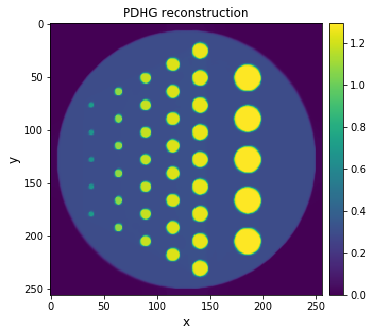

In [9]:
reg_parameter = 200
iterations = 50
tolerance = 1e-6
methodTV = 0
pos_cons = 1
printing = 0
device = 'gpu'

G = FGP_TV(reg_parameter, iterations, tolerance, methodTV, pos_cons, printing, device)

K = A

normK = K.norm()
sigma = 1
tau = 1/(sigma * normK**2)

# Setup and run the PDHG algorithm
pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, 
            max_iteration = 200)
pdhg.run(verbose=False)
pdhg_recon = pdhg.get_output()
show(pdhg_recon, title = 'PDHG reconstruction')

# Exercise 1: 3D TV reconstruction

In this exercise, we will solve a TV reconstruction problem using the two methods described above. We will load a 3D tomophantom from the [list](https://github.com/dkazanc/TomoPhantom/blob/master/PhantomLibrary/models/Phantom3DLibrary.dat). For example, we select _model=12_ for a 3D Shepp-Logan phantom. 

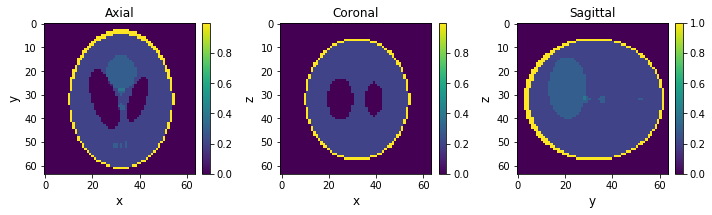

interactive(children=(IntSlider(value=32, continuous_update=False, description='x', max=63), Output()), _dom_c…

IntSlider(value=32, continuous_update=False, description='x', max=63)

In [11]:
model = 13 # select a model number from the library
N = 64 # Define phantom dimensions using a scalar value (cubic phantom)
path = os.path.dirname(tomophantom.__file__)
path_library3D = os.path.join(path, "Phantom3DLibrary.dat")
#This will generate a N_size x N_size x N_size phantom (3D)
phantom_tm = ImageData(TomoP3D.Model(model, N, path_library3D))

# Define image geometry.
ig = ImageGeometry(voxel_num_x = N, voxel_num_y=N, voxel_num_z=N)
im_data = ig.allocate()
im_data.fill(phantom_tm)

# Show data in Axial, Coronal and Sagittal view
show(im_data)

# Use islicer 
islicer(im_data, 2, slice_number = 32) # value=32)

Then, we define our AcqusitionGeometry, AstraProjector and our AcquisitionData for the 3D case.

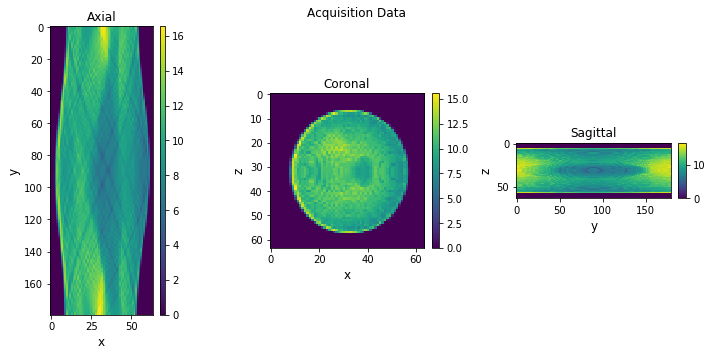

In [12]:
angles = np.linspace(0, np.pi, 180, dtype='float32')
ag = AcquisitionGeometry('parallel',
                         '3D',
                         angles,
                         pixel_num_h = N,
                         pixel_num_v = N)

A = AstraProjector3DSimple(ig, ag)
sino_num = A.direct(im_data)

# show sino add title
show(sino_num, title = 'Acquisition Data')

## Part (a)

For the first part, we would like to reconstruct using:

1. FBP with a 'ram-lak' filter.
1. SIRT with a positivity constraint.
1. CGLS.

In [13]:
# Run FBP reconstruction 

### START CODE HERE (3 lines) ### 
    
    # fbp3D = ... 
    # fbp3D = ... 
    # fbp3D = ... 
    
### END CODE HERE ###


# Run SIRT reconstruction 

### START CODE HERE (4 lines) ### 
    
    # x_init = 
    # sirt3D = ... 
    # sirt3D = ... 
    # sirt3D = ... 
    
### END CODE HERE ###


# Run CGLS reconstruction 

### START CODE HERE (4 lines) ### 
    
    # x_init = 
    # cgls3D = ... 
    # cgls3D = ... 
    # cgls3D = ... 
    
### END CODE HERE ###


# SHOW RECONCTRUCTIONS

In [14]:
# Run FBP reconstruction 
fbp3D = FBP(ig, ag, 'ram-lak')
fbp3D.set_input(sino_num)
fbp3D_recon = fbp3D.get_output()

# Run SIRT reconstruction 
x_init = ig.allocate()  
sirt3D = SIRT(x_init = x_init, operator = A, data=sino_num, constraint = IndicatorBox(lower=0),
           max_iteration = 50)
sirt3D.run(verbose=False)
sirt3D_recon = sirt3D.get_output()

# Run CGLS reconstruction 
cgls3D = CGLS(x_init = x_init, operator = A, data = sino_num, max_iteration = 10)
cgls3D.run(verbose = False)
cgls3D_recon = cgls3D.get_output()

SIRT setting up
SIRT configured
CGLS setting up
CGLS configured


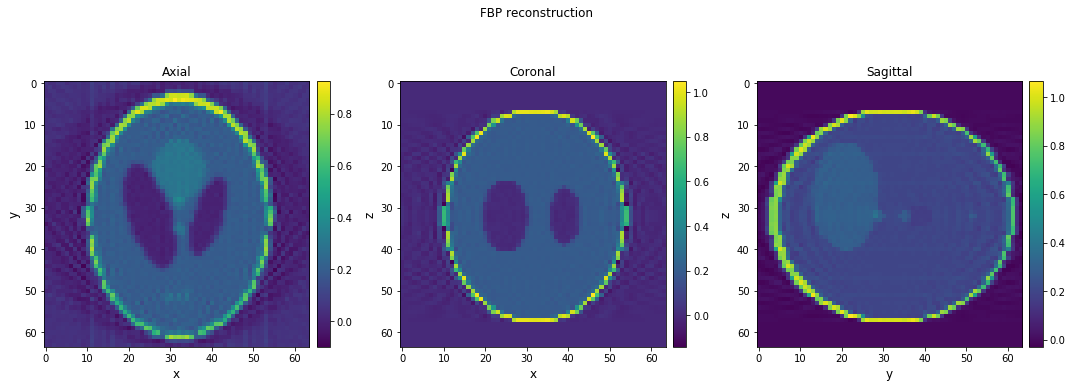

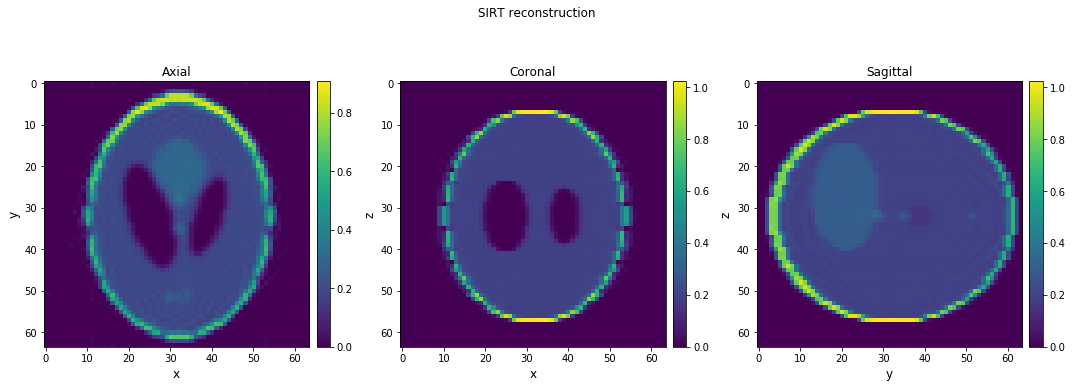

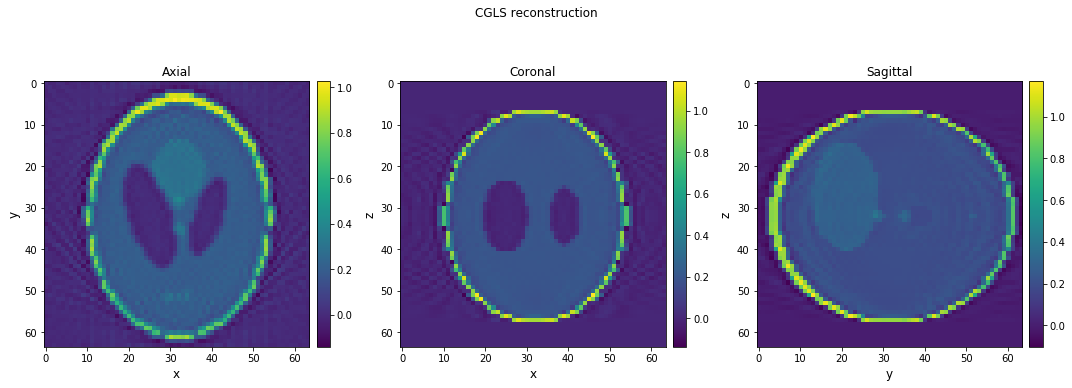

In [15]:
show(fbp3D_recon, title = 'FBP reconstruction', figure_size = (15,6))
show(sirt3D_recon, title = 'SIRT reconstruction',  figure_size = (15,6))
show(cgls3D_recon, title = 'CGLS reconstruction', figure_size = (15,6))

## Part (b)

For the second part, we would like to reconstruct using the Total variation regulariser and the two method of PDHG:

### PDHG split

1. Define a BlockOperator K with the Gradient and Projection operators.
1. Define a BlockFunction F with the MixedL21Norm() and the L2NormSquared(sino_num).
1. Define a function G for the positivity constraint IndicatorBox(lower=0).
1. Compute operator norm of K and define sigma,tau step-sizes such that sigma*tau||K||^{2}<1.
1. Setup and run PDHG.

### PDHG explicit

1. Define an operator K as the Projection operator A.
1. Define a function F as the L2NormSquared(sino_num).
1. Define a _function_ G, which solves a Total variation denosing problem using the _Fast Gradient Projection_ algoritm, i.e.,
    
    __G = FGP_TV(reg_parameter, iterations, tolerance, methodTV, pos_cons, printing, device)__. 
    
    Do not forget to enforce the positivity constraint.
    
1. Compute operator norm of K and define sigma,tau step-sizes such that $\sigma\tau\|K\|^{2}<1$.
1. Setup and run PDHG


In [16]:
# Part (b)

    ############
    # PDHG split
    ############
    
    ### START CODE HERE (2 lines) ### 

        # Grad =     
        # K = 

    ### END CODE HERE ###
    
    ### START CODE HERE (3 lines) ### 

        # f1 =
        # f2 = 
        # F = 

    ### END CODE HERE ### 
    
    ### START CODE HERE (1 line) ### 

        # G = 

    ### END CODE HERE ###     
    
    ### START CODE HERE (3 lines) ### 

        # normK =
        # sigma = 
        # tau = 

    ### END CODE HERE ### 
    
    ### START CODE HERE (2 lines) ### 

        # pdhg = ...
        # pdhg ...

    ### END CODE HERE ### 
    
    # SHOW RECONSTRUCTION

    #####################################

    ###############
    # PDHG explicit
    ###############
    
    ### START CODE HERE (1 line) ### 

        # K =      

    ### END CODE HERE ###
    
    ### START CODE HERE (1 line) ### 

        # F =      

    ### END CODE HERE ###
    
    ### START CODE HERE (1 line) ### 

        # G =      

    ### END CODE HERE ###
    
    ### START CODE HERE (3 lines) ### 

        # normK =
        # sigma = 
        # tau = 

    ### END CODE HERE ### 
    
    ### START CODE HERE (2 lines) ### 

        # pdhg = ...
        # pdhg ...

    ### END CODE HERE ### 
    
    # SHOW RECONSTRUCTION

In [17]:
Grad = Gradient(ig)
K = BlockOperator(Grad, A)

alpha = 10
f1 = alpha * MixedL21Norm()
f2 = 0.5 * L2NormSquared(sino_num)
F = BlockFunction(f1, f2)

G = IndicatorBox(lower=0)

normK = K.norm()
sigma = 1
tau = 1/(sigma*normK**2)

pdhg3D = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, max_iteration = 200)
pdhg3D.run(verbose=False)
pdhg3D_split = pdhg3D.get_output()

PDHG setting up
PDHG configured


PDHG setting up
PDHG configured


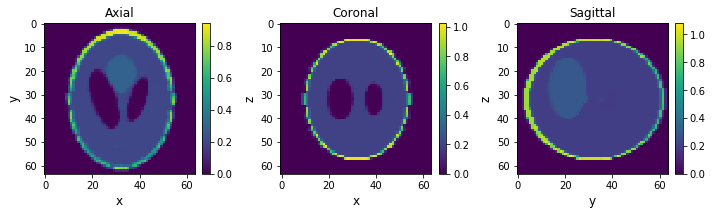

In [23]:
K = A
F = f2
G = FGP_TV(alpha, 50, 1e-6, 0, 1, 0, 'gpu')

normK = K.norm()
sigma = 1
tau = 1/(sigma*normK**2)

pdhg3D = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, max_iteration = 200)
pdhg3D.run(verbose=False)
pdhg3D_explicit = pdhg3D.get_output()
show(pdhg3D_explicit)

In [21]:
islicer(fbp3D_recon, 0, title = 'FBP', slice_number = 32)
islicer(sirt3D_recon, 0, title = 'SIRT', slice_number = 32)
islicer(cgls3D_recon, 0, title = 'CGLS', slice_number = 32)
islicer(pdhg3D_split, 0, title = 'PDHG with BlockFramework', slice_number = 32)
islicer(pdhg3D_explicit, 0, title = 'PDHG without BlockFramwork', slice_number = 32)

interactive(children=(IntSlider(value=32, continuous_update=False, description='x', max=63), Output()), _dom_c…

interactive(children=(IntSlider(value=32, continuous_update=False, description='x', max=63), Output()), _dom_c…

interactive(children=(IntSlider(value=32, continuous_update=False, description='x', max=63), Output()), _dom_c…

interactive(children=(IntSlider(value=32, continuous_update=False, description='x', max=63), Output()), _dom_c…

interactive(children=(IntSlider(value=32, continuous_update=False, description='x', max=63), Output()), _dom_c…

IntSlider(value=32, continuous_update=False, description='x', max=63)

<h1><center>End of Part II </center></h1>